In [ ]:
#!cd yolov5 && python train.py --img 320 --batch 9 --epochs 250 --data dataset_2_P4_and_TB2.yml --weights yolov5s.pt --workers 4

In [4]:
# The Last for save detected satellite images + send satellite_information Like Name,X,Y,Z Coordinates to database Excel  
# 1. Локализация объекта (спутника) с использованием YOLOv5 на видеокадрах.

import cv2
import torch
import numpy as np
import pandas as pd
import os

model = torch.hub.load('ultralytics/yolov5', 'custom', path='C:/Users/L/yolov5/runs/Satallite/exp/weights/last.pt', force_reload=True)

def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)     

def detect_and_store_information(input_path, new_width, new_height, output_folder, excel_filename, record_video=False):

    detect_images_folder = os.path.join(output_folder, 'Detected_images')
    video_folder = os.path.join(output_folder, 'Video')

    create_directory(detect_images_folder)  # Create folder to store detected satellite images
    create_directory(video_folder)  # Create folder to store recorded video

    cap = cv2.VideoCapture(input_path)
    satellite_count = 0

    # Lists to store satellite information
    satellite_names, x_coords, y_coords, z_coords = [], [], [], []

    # Define the codec and create VideoWriter object if recording is enabled
    if record_video:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(os.path.join(video_folder, 'output.avi'), fourcc, 20.0, (new_width, new_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (new_width, new_height))
        results = model(frame)
        detected_satellites = results.xyxy[0]

        for sat_idx, sat in enumerate(detected_satellites):
            x1, y1, x2, y2, confidence, class_id = sat
            satellite_name = f"Satellite_{satellite_count}_{sat_idx}"
            x_coord = int((x1 + x2) / 2)
            y_coord = int((y1 + y2) / 2)
            z_coord = int((x_coord + y_coord) * 1.5)  # Calculating z as (x + y) * 1.5    
            
            # Crop the detected satellite from the frame
            cropped_satellite = frame[int(y1):int(y2), int(x1):int(x2)]
          
            # Save the cropped satellite image to the detect_images folder
            cv2.imwrite(os.path.join(detect_images_folder, f"{satellite_name}.jpg"), cropped_satellite)
            
            # Append satellite information to lists
            satellite_names.append(satellite_name)
            x_coords.append(x_coord)
            y_coords.append(y_coord)
            z_coords.append(z_coord)

            satellite_count += 1

        cv2.imshow('YOLO', np.squeeze(results.render()))
        
        # Write the frame into the output video if recording is enabled
        if record_video:
            out.write(frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Create a DataFrame from the collected data
    data = {
        'Satellite Name': satellite_names,
        'X-coordinate': x_coords,
        'Y-coordinate': y_coords,
        'Z-coordinate': z_coords,  # Include Z-coordinate in the DataFrame
    }
    df = pd.DataFrame(data)

    # Save the DataFrame to an Excel file
    df.to_excel(excel_filename, index=False)

    cap.release()
    cv2.destroyAllWindows()
    
    if record_video:
        out.release()

# Example usage
input_video_path = 'D:/Python_Project_Tracking/Untitled_Project_V1.mp4'
new_width = 640
new_height = 480
output_folder = 'D:/Python_Project_Tracking'  # Base folder to contain detect_images and video folders
excel_filename = 'D:/Python_Project_Tracking/satellite_information.xlsx'

detect_and_store_information(input_video_path, new_width, new_height, output_folder, excel_filename, record_video=True)



Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\L/.cache\torch\hub\master.zip
YOLOv5  2024-2-29 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7053277 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


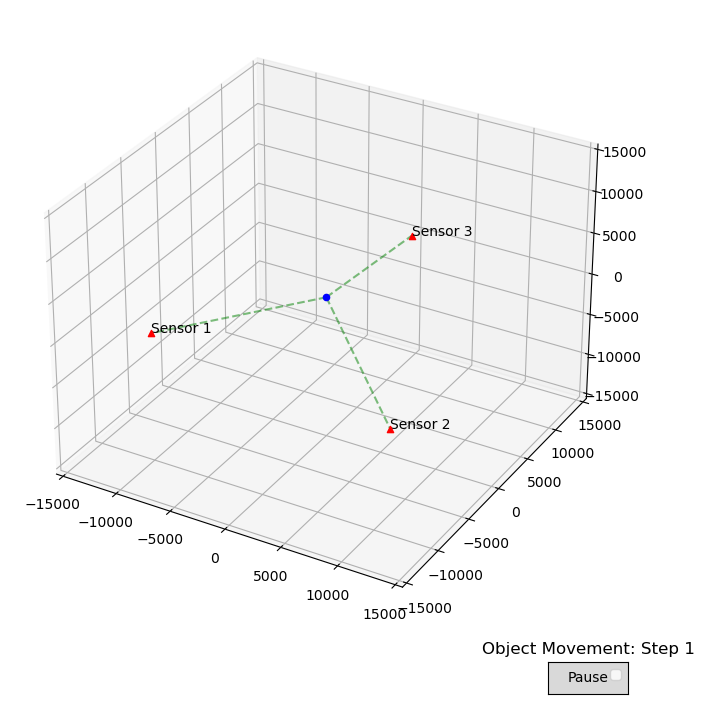

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


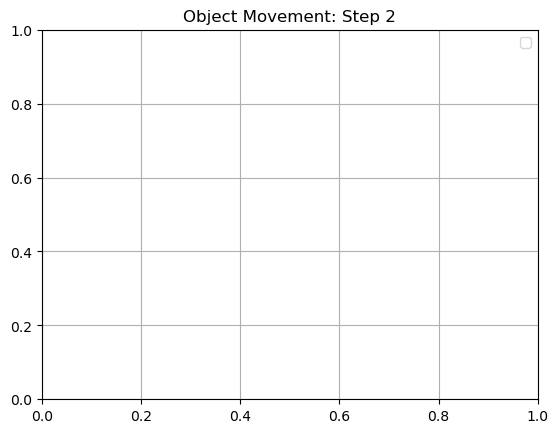

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


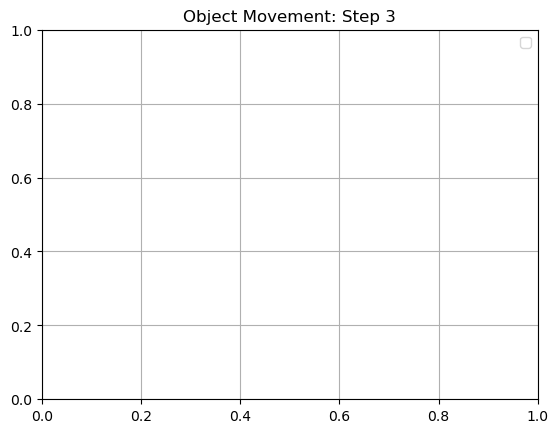

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


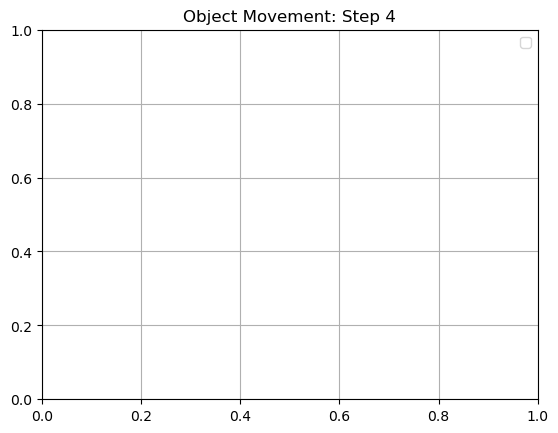

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


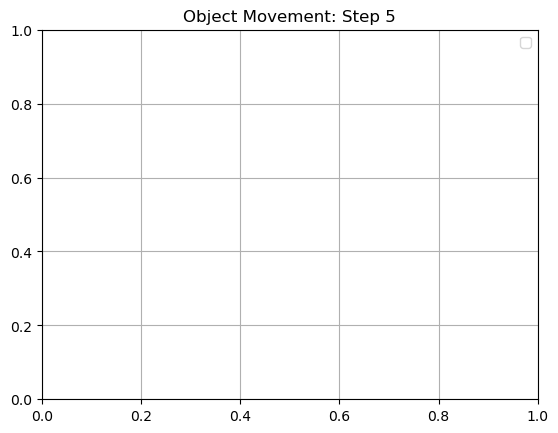

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


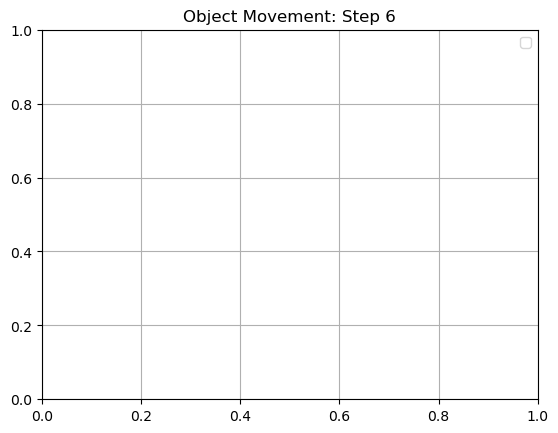

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


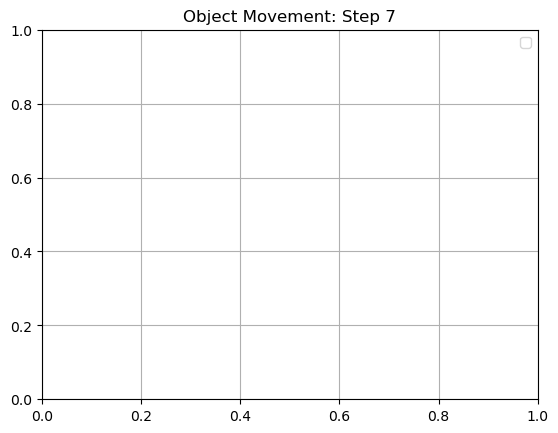

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


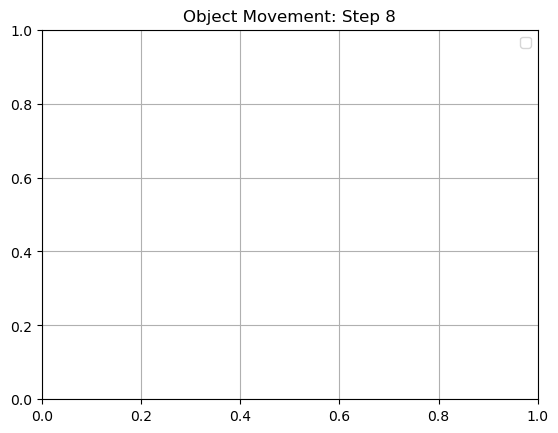

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


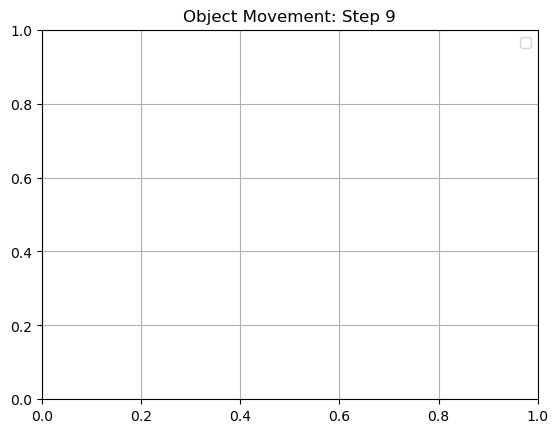

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


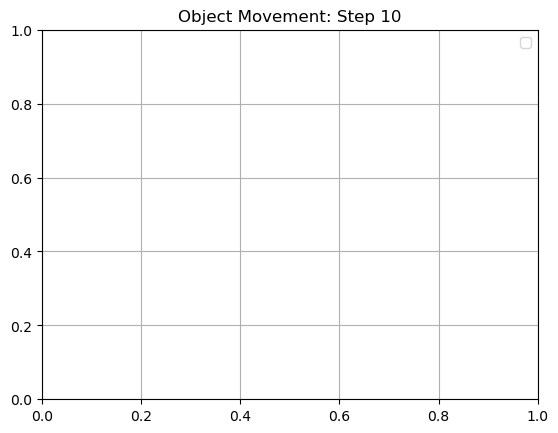

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


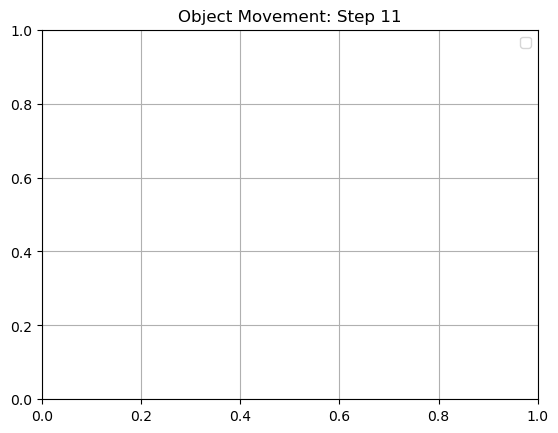

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


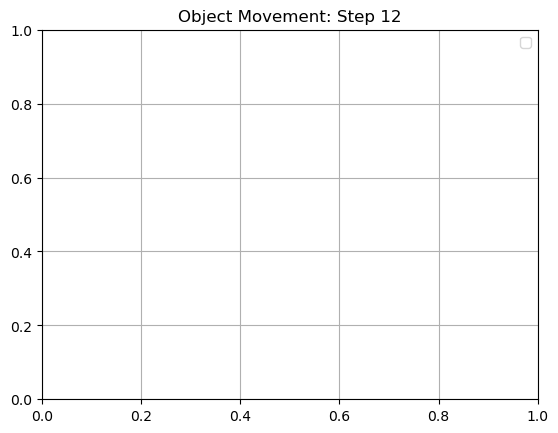

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


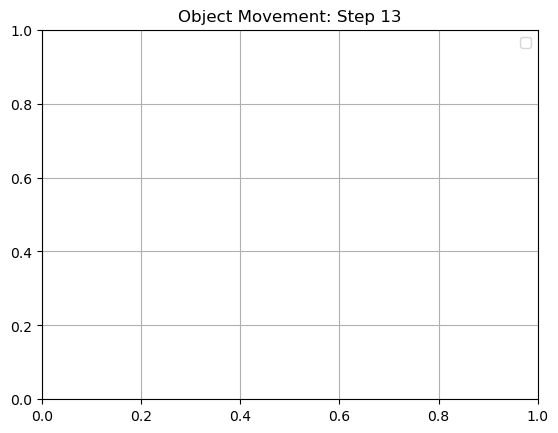

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


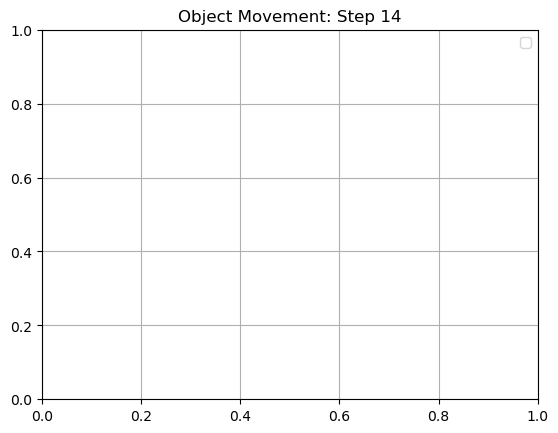

KeyboardInterrupt: 

In [5]:
# The last - visualize the movement of our object and store every step of the movment in our database(local folder) like and image
 # 2. 3D визуализация движения объекта (спутника) и близости датчиков.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.widgets import Button
import os

# Load data from satellite_information.xlsx
data = pd.read_excel('D://Python_Project_Tracking//position_data.xlsx')
output_folder = 'D://Python_Project_Tracking//Object_Movement_1'

def save_step_image(step_num, fig):
    folder_path = output_folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(os.path.join(folder_path, f'step_{step_num:03d}.png'))

# Extract X, Y, and Z coordinates from the loaded data
object_positions_x = data['X'].tolist()
object_positions_y = data['Y'].tolist()
object_positions_z = data['Z'].tolist()

# Define sensor positions within the range of -100 to 1000 for x, y, and z axes
sensor_positions = [
    (-10000, -10000, 0),  # Sensor 1 position (x, y, z)
    (13000, -13000, 0),  # Sensor 2 position (x, y, z)
    (0, 14000, 0),       # Sensor 3 position (x, y, z)
]

# Create a 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')  # Adding a 3D subplot

# Set limits for x, y, and z axes
ax.set_xlim(-15000, 15000)
ax.set_ylim(-15000, 15000)
ax.set_zlim(-15000, 15000)

# Plot sensor positions in 3D
for sensor_pos in sensor_positions:
    ax.scatter(sensor_pos[0], sensor_pos[1], sensor_pos[2], color='red', marker='^', label='Sensor')

# Label sensors in 3D
sensor_labels = ['Sensor 1', 'Sensor 2', 'Sensor 3']
for i, sensor_pos in enumerate(sensor_positions):
    ax.text(sensor_pos[0], sensor_pos[1], sensor_pos[2], sensor_labels[i], color='black', fontsize=10)

# Initialize variables for simulation control
paused = False
current_step = 0
sensor_lines = []  # Store sensor lines
exit_simulation = False  # Define the exit_simulation flag

def toggle_pause(event):
    global paused
    paused = not paused

    if paused:
        button.label.set_text('Resume')
    else:
        button.label.set_text('Pause')
        simulate(current_step)  # Resume simulation from the current step

# Pause/Resume button
button_ax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(button_ax, 'Pause')
button.on_clicked(toggle_pause)

def on_key(event):
    global paused, exit_simulation
    if event.key == 'q':
        exit_simulation = True

fig.canvas.mpl_connect('key_press_event', on_key)

def simulate(start_step=0):
    global current_step, paused, sensor_lines, exit_simulation

    for i in range(start_step, len(object_positions_x)):
        if exit_simulation:
            break

        if not paused:
            current_step = i

            scaling_factor = 3
            object_x = object_positions_x[i] * scaling_factor
            object_y = object_positions_y[i] * scaling_factor
            object_z = object_positions_z[i] * scaling_factor  # Fetch the Z-coordinate

            ax.scatter(object_x, object_y, object_z, color='blue', marker='o', label='Object Position')

            if i > 0:  # Connect consecutive object positions with a line
                ax.plot([object_positions_x[i-1]*scaling_factor, object_x],
                        [object_positions_y[i-1]*scaling_factor, object_y],
                        [object_positions_z[i-1]*scaling_factor, object_z],
                        color='green', linestyle='-', label='_nolegend_')

            # Remove previous sensor lines
            for line in sensor_lines:
                line.remove()

            sensor_lines = []  # Clear sensor lines list for new lines

            # Draw sensor lines
            for sensor_pos in sensor_positions:
                sensor_line = ax.plot([object_x, sensor_pos[0]],
                                      [object_y, sensor_pos[1]],
                                      [object_z, sensor_pos[2]],
                                      linestyle='--', color='green', alpha=0.5, label='_nolegend_')
                sensor_lines.append(sensor_line[0])

            plt.title(f'Object Movement: Step {i+1}')
            plt.legend()
            plt.grid(True)
            save_step_image(i, fig)
            plt.pause(0.1)

    if not exit_simulation:
        plt.close(fig)  # Close the figure if simulation completes without 'q' key press

# Start simulation
simulate()

# Check if the simulation is paused before displaying the plot
if paused:
    plt.show()
else:
    plt.show(block=False)  # Set block=False to keep the figure open without blocking code execution



In [8]:
# Convert images (steps of the movment pf our object) to video 
# 3. Создание видео движения объекта (спутника) из 3D снимков.

import cv2
import os

# Path to the directory containing images
images_folder = 'D://Python_Project_Tracking//Object_Movement_1'  # Path to your image folder

# List all image files in the directory
image_files = sorted([os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))])

# Get the first image to extract dimensions
first_image = cv2.imread(image_files[0])
height, width, layers = first_image.shape

# Video filename and codec
video_filename = 'D://Python_Project_Tracking//Object_Movement_1.mp4'  # Path for the output video
codec = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4

# Create VideoWriter object
video = cv2.VideoWriter(video_filename, codec, 24, (width, height))

# Write images to video
for image in image_files:
    img = cv2.imread(image)
    video.write(img)

# Release video object
video.release()


In [4]:
# 4. Реально-временный пространственный анализ динамики спутника-наблюдателя в 3D пространстве.

import pandas as pd
import numpy as np

# Function to calculate altitude from three angle measurements
def calculate_altitude(angle_observer_a, angle_observer_b, angle_observer_c, 
                       distance_between_observers_1, distance_between_observers_2, distance_between_observers_3):
    angle_observer_a_rad = np.deg2rad(angle_observer_a)
    angle_observer_b_rad = np.deg2rad(angle_observer_b)
    angle_observer_c_rad = np.deg2rad(angle_observer_c)

    altitude_1 = distance_between_observers_1 * np.tan(angle_observer_a_rad) * np.tan(angle_observer_b_rad) / (
            np.tan(angle_observer_a_rad) - np.tan(angle_observer_b_rad))

    altitude_2 = distance_between_observers_2 * np.tan(angle_observer_b_rad) * np.tan(angle_observer_c_rad) / (
            np.tan(angle_observer_b_rad) - np.tan(angle_observer_c_rad))

    altitude_3 = distance_between_observers_3 * np.tan(angle_observer_a_rad) * np.tan(angle_observer_c_rad) / (
            np.tan(angle_observer_a_rad) - np.tan(angle_observer_c_rad))

    return altitude_1, altitude_2, altitude_3


def get_distances(x1, y1, z1, x2, y2, z2, x3, y3, z3):
    distance_1_2 = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)
    distance_2_3 = np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2 + (z2 - z3) ** 2)
    distance_1_3 = np.sqrt((x1 - x3) ** 2 + (y1 - y3) ** 2 + (z1 - z3) ** 2)

    return distance_1_2, distance_2_3, distance_1_3

def get_angle_measurements_and_distance(x_coord, y_coord, z_coord, x1, y1, z1, x2, y2, z2, x3, y3, z3):
    distance_1 = np.sqrt((x_coord - x1) ** 2 + (y_coord - y1) ** 2 + (z_coord - z1) ** 2)
    distance_2 = np.sqrt((x_coord - x2) ** 2 + (y_coord - y2) ** 2 + (z_coord - z2) ** 2)
    distance_3 = np.sqrt((x_coord - x3) ** 2 + (y_coord - y3) ** 2 + (z_coord - z3) ** 2)

    angle_observer_a = np.arctan2(z_coord - z1, distance_1)
    angle_observer_b = np.arctan2(z_coord - z2, distance_2)
    angle_observer_c = np.arctan2(z_coord - z3, distance_3)

    return angle_observer_a, angle_observer_b, angle_observer_c, distance_1, distance_2, distance_3

def main():
    x1, y1, z1 = 100, 200, 50
    x2, y2, z2 = 300, 500, 800
    x3, y3, z3 = 800, 700, 900

    excel_file_path = "D://Python_Project_Tracking//satellite_information.xlsx"
    df = pd.read_excel(excel_file_path)

    all_data = []

    for i in range(len(df)):
        x_coord, y_coord, z_coord = df.iloc[i, 1:4].tolist()

        distance_1_2, distance_2_3, distance_1_3 = get_distances(x1, y1, z1, x2, y2, z2, x3, y3, z3)

        angle_observer_a, angle_observer_b, angle_observer_c, distance_1, distance_2, distance_3 = \
            get_angle_measurements_and_distance(x_coord, y_coord, z_coord, x1, y1, z1, x2, y2, z2, x3, y3, z3)

        altitude_1, altitude_2, altitude_3 = calculate_altitude(
            np.degrees(angle_observer_a), np.degrees(angle_observer_b), np.degrees(angle_observer_c),
            distance_1_2, distance_2_3, distance_1_3
        )

        all_data.append([x_coord, y_coord, z_coord, x1, y1, z1, x2, y2, z2, x3, y3, z3,
                         distance_1_2, distance_2_3, distance_1_3,
                         np.degrees(angle_observer_a), np.degrees(angle_observer_b), np.degrees(angle_observer_c),
                         altitude_1, altitude_2, altitude_3, distance_1, distance_2, distance_3])

    columns = ['X_Object', 'Y_Object', 'Z_Object', 'X_Observer1', 'Y_Observer1', 'Z_Observer1',
               'X_Observer2', 'Y_Observer2', 'Z_Observer2', 'X_Observer3', 'Y_Observer3', 'Z_Observer3',
               'Distance_Observer1_2', 'Distance_Observer2_3', 'Distance_Observer1_3',
               'Angle_Observer1', 'Angle_Observer2', 'Angle_Observer3',
               'Altitude_Observer1', 'Altitude_Observer2', 'Altitude_Observer3',
               'Distance_Object_Observer1', 'Distance_Object_Observer2', 'Distance_Object_Observer3']

    result_df = pd.DataFrame(all_data, columns=columns)

    result_df.to_excel("D://Python_Project_Tracking//Time_Spatial_Analysis_Results.xlsx", index=False)
    print("Data sending operation completed.")

if __name__ == "__main__":
    main()


Data sending operation completed.


In [11]:
# The Last - visualize all changes and store it in separate folders in the local system
# 5. Динамическая визуализация координат для объекта (спутника) и наблюдателей.

import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to create directories if they don't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Directory paths for saving plots
directories = [
    "D://Python_Project_Tracking//Coordinate_Plots_Object",
    "D://Python_Project_Tracking//Coordinate_Plots_Observer1",
    "D://Python_Project_Tracking//Coordinate_Plots_Observer2",
    "D://Python_Project_Tracking//Coordinate_Plots_Observer3",
    "D://Python_Project_Tracking//Coordinate_Plots_Distances_Observers",
    "D://Python_Project_Tracking//Coordinate_Plots_Angles",
    "D://Python_Project_Tracking//Coordinate_Plots_Distances_Object_Observer",
    "D://Python_Project_Tracking//Coordinate_Plots_Altitude_Observers"
]

# Create directories if they don't exist
for directory in directories:
    create_directory(directory)

# Load the data from the result_coordinates.xlsx file
file_path = "D://Python_Project_Tracking//Time_Spatial_Analysis_Results.xlsx"
df = pd.read_excel(file_path)

# Coordinates to plot
object_coordinates = ['X_Object', 'Y_Object', 'Z_Object']
observer1_coordinates = ['X_Observer1', 'Y_Observer1', 'Z_Observer1']
observer2_coordinates = ['X_Observer2', 'Y_Observer2', 'Z_Observer2']
observer3_coordinates = ['X_Observer3', 'Y_Observer3', 'Z_Observer3']
distance_coordinates = ['Distance_Observer1_2', 'Distance_Observer2_3', 'Distance_Observer1_3']
angle_coordinates = ['Angle_Observer1', 'Angle_Observer2', 'Angle_Observer3']
observer_object_distance_coordinates = ['Distance_Object_Observer1', 'Distance_Object_Observer2', 'Distance_Object_Observer3']
altitude_coordinates = ['Altitude_Observer1', 'Altitude_Observer2', 'Altitude_Observer3']

# Function to plot and save coordinates
def plot_coordinates(coordinates, directory, title_prefix):
    for coord in coordinates:
        plt.figure(figsize=(8, 6))
        plt.plot(df.index, df[coord])
        plt.title(f"{title_prefix} - Change in {coord} over Time")
        plt.xlabel('Time')
        plt.ylabel(coord)
        plt.grid(True)
        plt.savefig(f"{directory}//{coord}_change.png")  # Save each plot for the coordinates
        plt.close()

# Plot and save coordinates for each set of coordinates
plot_coordinates(object_coordinates, directories[0], "Object")
plot_coordinates(observer1_coordinates, directories[1], "Observer 1")
plot_coordinates(observer2_coordinates, directories[2], "Observer 2")
plot_coordinates(observer3_coordinates, directories[3], "Observer 3")
plot_coordinates(distance_coordinates, directories[4], "Distances_Observers")
plot_coordinates(angle_coordinates, directories[5], "Angles")
plot_coordinates(observer_object_distance_coordinates, directories[6], "Distances_Object_Observer")
plot_coordinates(altitude_coordinates, directories[7], "Altitude_Observers")

print("All visualizations have been generated and stored successfully.")


All visualizations have been generated and stored successfully.


In [ ]:
'''Floating-point arithmetic in computers has limitations due to the way they represent and store real numbers. These limitations can lead to precision issues and rounding errors. Python, like many programming languages, uses floating-point representation to store decimal numbers. However, the internal representation of decimal numbers in computers is not exact and can lead to small discrepancies in calculations.

For instance, calculations involving very small or very large numbers, repeated operations, or operations that involve irrational numbers can exhibit these differences. Additionally, mathematical operations might yield results slightly different from what we expect due to the limited precision of floating-point numbers.

Python's floating-point arithmetic operates within these constraints, and while it provides high precision for most purposes, certain calculations might yield results that differ slightly from mathematical expectations. This behavior is common across programming languages and is inherent to the way computers handle floating-point numbers. Strategies like rounding or using higher precision arithmetic libraries can sometimes help mitigate these issues, but they might not eliminate them entirely.'''

In [1]:
# Triangulation 
# 6. Триангуляция для определения позиции объекта (спутника).

import pandas as pd
import numpy as np

# Load the data from the Excel file
file_path = "D://Python_Project_Tracking//Time_Spatial_Analysis_Results.xlsx"
df = pd.read_excel(file_path)

# Coordinates and distances from the Excel columns
observer_coordinates = [
    ['X_Observer1', 'Y_Observer1', 'Z_Observer1'],
    ['X_Observer2', 'Y_Observer2', 'Z_Observer2'],
    ['X_Observer3', 'Y_Observer3', 'Z_Observer3']
]
distance_coordinates = ['Distance_Object_Observer1', 'Distance_Object_Observer2', 'Distance_Object_Observer3']
angle_coordinates = ['Angle_Observer1', 'Angle_Observer2', 'Angle_Observer3']

# Triangulation using distances and angles
def triangulation(df, observer_coords, distance_coords, angle_coords):
    # Collect observer coordinates, distances, and angles for each observer
    observers = []
    for i in range(3):
        observer = df[observer_coords[i]].values
        distance = df[distance_coords[i]].values
        angle = np.radians(df[angle_coords[i]].values)
        observers.append({'observer': observer, 'distance': distance, 'angle': angle})

    # Perform triangulation
    results = []
    for i in range(len(df)):
        A = np.vstack([
            -np.cos(observers[0]['angle'][i]), -np.sin(observers[0]['angle'][i]), 1,
            -np.cos(observers[1]['angle'][i]), -np.sin(observers[1]['angle'][i]), 1,
            -np.cos(observers[2]['angle'][i]), -np.sin(observers[2]['angle'][i]), 1
        ]).reshape((3, 3))

        b = np.vstack([
            -observers[0]['distance'][i] * np.cos(observers[0]['angle'][i]),
            -observers[1]['distance'][i] * np.cos(observers[1]['angle'][i]),
            -observers[2]['distance'][i] * np.cos(observers[2]['angle'][i])
        ])

        # Calculate triangulation coordinates
        triangulation_coord = np.linalg.inv(A.T @ A) @ A.T @ b
        results.append(triangulation_coord.T)

    return np.array(results)

# Perform triangulation with distances and angles
triangulation_result = triangulation(df, observer_coordinates, distance_coordinates, angle_coordinates)

# Reshape the array to 2D for Excel compatibility
reshaped_result = triangulation_result.reshape(triangulation_result.shape[0], -1)

# Convert the reshaped array to a DataFrame
result_df = pd.DataFrame(reshaped_result)

# Add header for X, Y, Z as the first row
result_df.columns = ['X', 'Y', 'Z']

# Define the path for the new Excel file
output_file_path = "D://Python_Project_Tracking//triangulation_results.xlsx"

# Write the DataFrame to an Excel file with headers
result_df.to_excel(output_file_path, index=False)

# Display a message when the saving is completed
print(f"Triangulation results saved to {output_file_path}")


Triangulation results saved to D://Python_Project_Tracking//triangulation_results.xlsx


In [26]:
''' import pandas as pd
import matplotlib.pyplot as plt
import os

# Load data from 'D://Python_Project_Tracking//triangulation_results.xlsx'
data = pd.read_excel('D://Python_Project_Tracking//triangulation_results.xlsx')

output_folder = 'D://Python_Project_Tracking//Positional_Lines'
os.makedirs(output_folder, exist_ok=True)

# Function to plot and save coordinates
def plot_coordinates(coordinates, directory, title_prefix):
    for coord in coordinates:
        plt.figure(figsize=(8, 6))
        plt.plot(range(len(data)), data[coord], marker='.')
        plt.title(f"{title_prefix} - Change in {coord} over Time")
        plt.xlabel('Step')
        plt.ylabel(coord)
        plt.grid(True)
        plt.savefig(f"{directory}//{coord}_change.png")  # Save each plot for the coordinates
        plt.close()

# Plot and save coordinates for X, Y, and Z
plot_coordinates(['X', 'Y', 'Z'], output_folder, "Object")'''


In [27]:
# 7. Визуальный анализ траектории координат объекта (спутника) в 3D пространстве во времени на основе результатов триангуляции.

import pandas as pd
import matplotlib.pyplot as plt
import os

# Load data from 'D://Python_Project_Tracking//triangulation_results.xlsx'
data = pd.read_excel('D://Python_Project_Tracking//position_data.xlsx')

output_folder = 'D://Python_Project_Tracking//Positional_Lines_true'
os.makedirs(output_folder, exist_ok=True)

# Function to plot and save coordinates
def plot_coordinates(coordinates, directory, title_prefix):
    for coord in coordinates:
        plt.figure(figsize=(8, 6))
        plt.plot(range(len(data)), data[coord], marker='.')
        plt.title(f"{title_prefix} - Change in {coord} over Time")
        plt.xlabel('Step')
        plt.ylabel(coord)
        plt.grid(True)
        plt.savefig(f"{directory}//{coord}_change.png")  # Save each plot for the coordinates
        plt.close()

# Plot and save coordinates for X, Y, and Z
plot_coordinates(['X', 'Y', 'Z'], output_folder, "Object")


In [ ]:
 # Triangulation results visualizations
# 8. Динамическая 3D визуализация траектории объекта (спутника) и взаимодействия сенсоров после процесса триангуляции.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.widgets import Button
import os

# Load data from satellite_information.xlsx
data = pd.read_excel('D://Python_Project_Tracking//position_data.xlsx')
output_folder = 'D://Python_Project_Tracking//Output_triangulation_results'

def save_step_image(step_num, fig):
    folder_path = output_folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(os.path.join(folder_path, f'step_{step_num:03d}.png'))

# Extract X, Y, and Z coordinates from the loaded data
object_positions_x = data['X'].tolist()
object_positions_y = data['Y'].tolist()
object_positions_z = data['Z'].tolist()

# Define sensor positions within the range of -100 to 1000 for x, y, and z axes
sensor_positions = [
    (-10000, -10000, 0),  # Sensor 1 position (x, y, z)
    (13000, -13000, 0),  # Sensor 2 position (x, y, z)
    (0, 14000, 0),       # Sensor 3 position (x, y, z)
]

# Create a 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')  # Adding a 3D subplot

# Set limits for x, y, and z axes
ax.set_xlim(-15000, 15000)
ax.set_ylim(-15000, 15000)
ax.set_zlim(-15000, 15000)

# Plot sensor positions in 3D
for sensor_pos in sensor_positions:
    ax.scatter(sensor_pos[0], sensor_pos[1], sensor_pos[2], color='red', marker='^', label='Sensor')

# Label sensors in 3D
sensor_labels = ['Sensor 1', 'Sensor 2', 'Sensor 3']
for i, sensor_pos in enumerate(sensor_positions):
    ax.text(sensor_pos[0], sensor_pos[1], sensor_pos[2], sensor_labels[i], color='black', fontsize=10)

# Initialize variables for simulation control
paused = False
current_step = 0
sensor_lines = []  # Store sensor lines
exit_simulation = False  # Define the exit_simulation flag

def toggle_pause(event):
    global paused
    paused = not paused

    if paused:
        button.label.set_text('Resume')
    else:
        button.label.set_text('Pause')
        simulate(current_step)  # Resume simulation from the current step

# Pause/Resume button
button_ax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(button_ax, 'Pause')
button.on_clicked(toggle_pause)

def on_key(event):
    global paused, exit_simulation
    if event.key == 'q':
        exit_simulation = True

fig.canvas.mpl_connect('key_press_event', on_key)

def simulate(start_step=0):
    global current_step, paused, sensor_lines, exit_simulation

    for i in range(start_step, len(object_positions_x)):
        if exit_simulation:
            break

        if not paused:
            current_step = i

            scaling_factor = 3
            object_x = object_positions_x[i] * scaling_factor
            object_y = object_positions_y[i] * scaling_factor
            object_z = object_positions_z[i] * scaling_factor  # Fetch the Z-coordinate

            ax.scatter(object_x, object_y, object_z, color='blue', marker='o', label='Object Position')

            if i > 0:  # Connect consecutive object positions with a line
                ax.plot([object_positions_x[i-1]*scaling_factor, object_x],
                        [object_positions_y[i-1]*scaling_factor, object_y],
                        [object_positions_z[i-1]*scaling_factor, object_z],
                        color='green', linestyle='-', label='_nolegend_')

            # Remove previous sensor lines
            for line in sensor_lines:
                line.remove()

            sensor_lines = []  # Clear sensor lines list for new lines

            # Draw sensor lines
            for sensor_pos in sensor_positions:
                sensor_line = ax.plot([object_x, sensor_pos[0]],
                                      [object_y, sensor_pos[1]],
                                      [object_z, sensor_pos[2]],
                                      linestyle='--', color='green', alpha=0.5, label='_nolegend_')
                sensor_lines.append(sensor_line[0])

            plt.title(f'Object Movement: Step {i+1}')
            plt.legend()
            plt.grid(True)
            save_step_image(i, fig)
            plt.pause(0.1)

    if not exit_simulation:
        plt.close(fig)  # Close the figure if simulation completes without 'q' key press

# Start simulation
simulate()

# Check if the simulation is paused before displaying the plot
if paused:
    plt.show()
else:
    plt.show(block=False)  # Set block=False to keep the figure open without blocking code execution



In [ ]:
# Convert images (steps of the movment pf our object) to video 
# 9. Создание видео движения объекта (спутника) из 3D снимков.

import cv2
import os

# Path to the directory containing images
images_folder = 'D://Python_Project_Tracking//Output'  # Path to your image folder

# List all image files in the directory
image_files = sorted([os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))])

# Get the first image to extract dimensions
first_image = cv2.imread(image_files[0])
height, width, layers = first_image.shape

# Video filename and codec
video_filename = 'D://Python_Project_Tracking//output_video.mp4'  # Path for the output video
codec = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4

# Create VideoWriter object
video = cv2.VideoWriter(video_filename, codec, 24, (width, height))

# Write images to video
for image in image_files:
    img = cv2.imread(image)
    video.write(img)

# Release video object
video.release()


In [ ]:
'''Accuracy Validation: After performing triangulation, compare the calculated positions with the virtual locations 
obtained from video detection. You can create a comparison function to evaluate the alignment between
the detected positions and expected positions based on observational data.
This function might calculate differences or metrics to verify accuracy.'''

In [35]:
# Accuracy Validatio
# 10. Виртуальный оценщик точности координатной триангуляции.

import pandas as pd

# Load original coordinates from video detection
original_df = pd.read_excel('D://Python_Project_Tracking//modified_coordinates_1.xlsx')

# Load triangulation results
triangulation_df = pd.read_excel("D://Python_Project_Tracking//modified_coordinates_2.xlsx")

# Ensure both DataFrames have the same number of rows or handle the mismatch
if original_df.shape[0] != triangulation_df.shape[0]:
    print("Number of rows in the DataFrames do not match. Adjusting...")

    # Adjust the DataFrames to have the same number of rows
    min_rows = min(original_df.shape[0], triangulation_df.shape[0])
    original_df = original_df.iloc[:min_rows]
    triangulation_df = triangulation_df.iloc[:min_rows]

# Extract coordinates from DataFrames
original_coords = original_df[['X', 'Y', 'Z']].values
triangulation_coords = triangulation_df[['X', 'Y', 'Z']].values

# Calculate differences or metrics to verify alignment
differences = triangulation_coords - original_coords

# Calculate metrics for accuracy validation
mean_difference = differences.mean()
rmse = ((differences ** 2).mean()) ** 0.5

# Print or use the calculated metrics
print(f"Mean Difference: {mean_difference}")
print(f"RMSE: {rmse}")


Mean Difference: 0.023398205781697615
RMSE: 0.3907837471672551


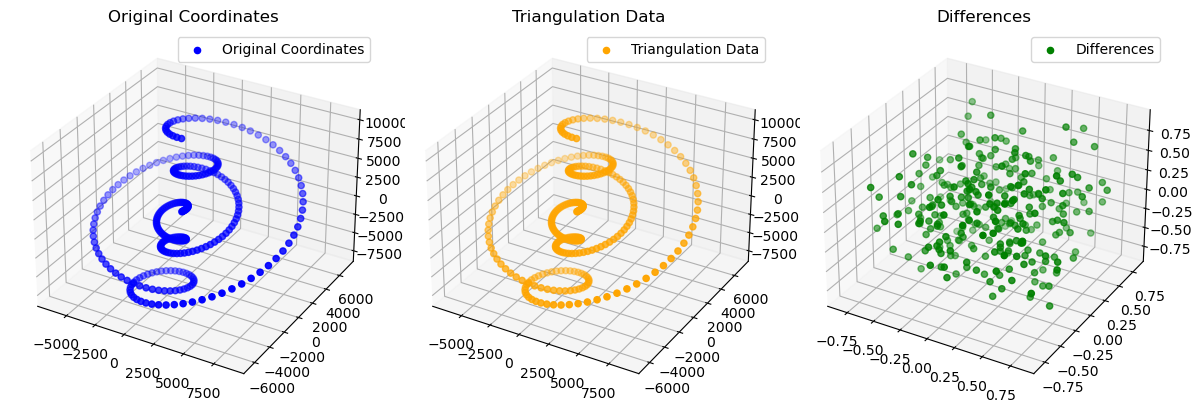

Mean Difference: 0.023398205781697615
RMSE: 0.3907837471672551


In [36]:
# Visualization of Accuracy Validation
# 11. Визуализация и проверка точности 3D координат.

import pandas as pd
import matplotlib.pyplot as plt

# Load original coordinates from video detection
original_df = pd.read_excel('D://Python_Project_Tracking//modified_coordinates_1.xlsx')

# Load triangulation results
triangulation_df = pd.read_excel("D://Python_Project_Tracking//modified_coordinates_2.xlsx")

# Ensure both DataFrames have the same number of rows or handle the mismatch
if original_df.shape[0] != triangulation_df.shape[0]:
    print("Number of rows in the DataFrames do not match. Adjusting...")

    # Adjust the DataFrames to have the same number of rows
    min_rows = min(original_df.shape[0], triangulation_df.shape[0])
    original_df = original_df.iloc[:min_rows]
    triangulation_df = triangulation_df.iloc[:min_rows]

# Extract coordinates from DataFrames
original_coords = original_df[['X', 'Y', 'Z']].values
triangulation_coords = triangulation_df[['X', 'Y', 'Z']].values

# Calculate differences or metrics to verify alignment
differences = triangulation_coords - original_coords

# Calculate metrics for accuracy validation
mean_difference = differences.mean()
rmse = ((differences ** 2).mean()) ** 0.5

# Visualization
fig = plt.figure(figsize=(12, 4))

# Plot original coordinates
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(*original_coords.T, label='Original Coordinates', c='blue')
ax1.set_title('Original Coordinates')
ax1.legend()

# Plot triangulation data
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(*triangulation_coords.T, label='Triangulation Data', c='orange')
ax2.set_title('Triangulation Data')
ax2.legend()

# Plot differences
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(*differences.T, label='Differences', c='green')
ax3.set_title('Differences')
ax3.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Print or use the calculated metrics
print(f"Mean Difference: {mean_difference}")
print(f"RMSE: {rmse}")


In [37]:
'''Error Correction and Adjustment: Discrepancies between the virtually determined location and triangulated results 
can highlight errors or inaccuracies in the video detection or remote sensing methods. By identifying these discrepancies, 
adjustments or corrections can be made to improve the accuracy of the virtual location data.
This process helps refine the virtual location by aligning it more closely with ground-based measurements.'''

'Error Correction and Adjustment: Discrepancies between the virtually determined location and triangulated results \ncan highlight errors or inaccuracies in the video detection or remote sensing methods. By identifying these discrepancies, \nadjustments or corrections can be made to improve the accuracy of the virtual location data.\nThis process helps refine the virtual location by aligning it more closely with ground-based measurements.'

In [34]:
# 12. Обнаружены расхождения.
# 13. Коррекция для расхождений триангуляции.

import pandas as pd

# Load original coordinates from video detection
original_df = pd.read_excel('D://Python_Project_Tracking//modified_coordinates_1.xlsx')

# Load triangulation results
triangulation_df = pd.read_excel("D://Python_Project_Tracking//modified_coordinates_2.xlsx")

# Ensure both DataFrames have the same number of rows or handle the mismatch
if original_df.shape[0] != triangulation_df.shape[0]:
    print("Number of rows in the DataFrames do not match. Adjusting...")

    # Adjust the DataFrames to have the same number of rows
    min_rows = min(original_df.shape[0], triangulation_df.shape[0])
    original_df = original_df.iloc[:min_rows]
    triangulation_df = triangulation_df.iloc[:min_rows]

# Extract coordinates from DataFrames
original_coords = original_df[['X', 'Y', 'Z']].values
triangulation_coords = triangulation_df[['X', 'Y', 'Z']].values

# Calculate differences or metrics to verify alignment
differences = triangulation_coords - original_coords

# Apply an adjustment factor to correct the differences
adjustment_factor = 0.99  # Adjust this value based on the analysis
adjusted_triangulated = triangulation_coords - (differences * adjustment_factor)

# Save adjusted triangulated data to a new Excel file
adjusted_df = pd.DataFrame(adjusted_triangulated, columns=['X', 'Y', 'Z'])
adjusted_df.to_excel('D://Python_Project_Tracking//adjusted_triangulated_coordinates.xlsx', index=False)

print("Adjusted triangulated coordinates saved to adjusted_triangulated_coordinates.xlsx")


Adjusted triangulated coordinates saved to adjusted_triangulated_coordinates.xlsx


In [35]:
# Accuracy Validatio
''' 

import pandas as pd

# Load original coordinates from video detection
original_df = pd.read_excel('D://Python_Project_Tracking//modified_coordinates_1.xlsx')

# Load triangulation results
triangulation_df = pd.read_excel("D://Python_Project_Tracking//adjusted_triangulated_coordinates.xlsx")

# Ensure both DataFrames have the same number of rows or handle the mismatch
if original_df.shape[0] != triangulation_df.shape[0]:
    print("Number of rows in the DataFrames do not match. Adjusting...")

    # Adjust the DataFrames to have the same number of rows
    min_rows = min(original_df.shape[0], triangulation_df.shape[0])
    original_df = original_df.iloc[:min_rows]
    triangulation_df = triangulation_df.iloc[:min_rows]

# Extract coordinates from DataFrames
original_coords = original_df[['X', 'Y', 'Z']].values
triangulation_coords = triangulation_df[['X', 'Y', 'Z']].values

# Calculate differences or metrics to verify alignment
differences = triangulation_coords - original_coords

# Calculate metrics for accuracy validation
mean_difference = differences.mean()
rmse = ((differences ** 2).mean()) ** 0.5

# Print or use the calculated metrics
print(f"Mean Difference: {mean_difference}")
print(f"RMSE: {rmse}")
'''

Mean Difference: 0.00023398205779556975
RMSE: 0.003907837471682074


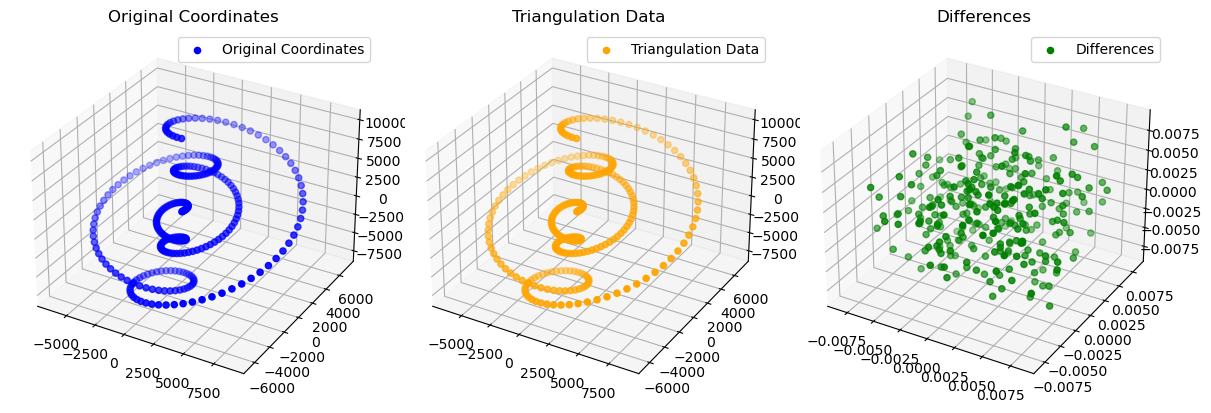

Mean Difference: 0.00023398205779556975
RMSE: 0.003907837471682074


In [36]:
# Visualization of Accuracy Validation
# 14. Проверка и визуализация скорректированных триангулированных координат.


import pandas as pd
import matplotlib.pyplot as plt

# Load original coordinates from video detection
original_df = pd.read_excel('D://Python_Project_Tracking//modified_coordinates_1.xlsx')

# Load triangulation results
triangulation_df = pd.read_excel("D://Python_Project_Tracking//adjusted_triangulated_coordinates.xlsx")

# Ensure both DataFrames have the same number of rows or handle the mismatch
if original_df.shape[0] != triangulation_df.shape[0]:
    print("Number of rows in the DataFrames do not match. Adjusting...")

    # Adjust the DataFrames to have the same number of rows
    min_rows = min(original_df.shape[0], triangulation_df.shape[0])
    original_df = original_df.iloc[:min_rows]
    triangulation_df = triangulation_df.iloc[:min_rows]

# Extract coordinates from DataFrames
original_coords = original_df[['X', 'Y', 'Z']].values
triangulation_coords = triangulation_df[['X', 'Y', 'Z']].values

# Calculate differences or metrics to verify alignment
differences = triangulation_coords - original_coords

# Calculate metrics for accuracy validation
mean_difference = differences.mean()
rmse = ((differences ** 2).mean()) ** 0.5

# Visualization
fig = plt.figure(figsize=(12, 4))

# Plot original coordinates
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(*original_coords.T, label='Original Coordinates', c='blue')
ax1.set_title('Original Coordinates')
ax1.legend()

# Plot triangulation data
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(*triangulation_coords.T, label='Triangulation Data', c='orange')
ax2.set_title('Triangulation Data')
ax2.legend()

# Plot differences
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(*differences.T, label='Differences', c='green')
ax3.set_title('Differences')
ax3.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Print or use the calculated metrics
print(f"Mean Difference: {mean_difference}")
print(f"RMSE: {rmse}")


In [ ]:
 # Triangulation results visualizations
# 15. 3D моделирование движения объекта после операции "Коррекция для расхождений триангуляции".


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.widgets import Button
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.widgets import Button
import os

# Load data from satellite_information.xlsx
data = pd.read_excel('D://Python_Project_Tracking//adjusted_triangulated_coordinates.xlsx')
output_folder = 'D://Python_Project_Tracking//Triangulation_After_modified'

def save_step_image(step_num, fig):
    folder_path = output_folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(os.path.join(folder_path, f'step_{step_num:03d}.png'))

# Extract X, Y, and Z coordinates from the loaded data
object_positions_x = data['X'].tolist()
object_positions_y = data['Y'].tolist()
object_positions_z = data['Z'].tolist()

# Define sensor positions within the range of -100 to 1000 for x, y, and z axes
sensor_positions = [
    (-10000, -10000, 0),  # Sensor 1 position (x, y, z)
    (13000, -13000, 0),  # Sensor 2 position (x, y, z)
    (0, 14000, 0),       # Sensor 3 position (x, y, z)
]

# Create a 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')  # Adding a 3D subplot

# Set limits for x, y, and z axes
ax.set_xlim(-15000, 15000)
ax.set_ylim(-15000, 15000)
ax.set_zlim(-15000, 15000)

# Plot sensor positions in 3D
for sensor_pos in sensor_positions:
    ax.scatter(sensor_pos[0], sensor_pos[1], sensor_pos[2], color='red', marker='^', label='Sensor')

# Label sensors in 3D
sensor_labels = ['Sensor 1', 'Sensor 2', 'Sensor 3']
for i, sensor_pos in enumerate(sensor_positions):
    ax.text(sensor_pos[0], sensor_pos[1], sensor_pos[2], sensor_labels[i], color='black', fontsize=10)

# Initialize variables for simulation control
paused = False
current_step = 0
sensor_lines = []  # Store sensor lines
exit_simulation = False  # Define the exit_simulation flag

def toggle_pause(event):
    global paused
    paused = not paused

    if paused:
        button.label.set_text('Resume')
    else:
        button.label.set_text('Pause')
        simulate(current_step)  # Resume simulation from the current step

# Pause/Resume button
button_ax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(button_ax, 'Pause')
button.on_clicked(toggle_pause)

def on_key(event):
    global paused, exit_simulation
    if event.key == 'q':
        exit_simulation = True

fig.canvas.mpl_connect('key_press_event', on_key)

def simulate(start_step=0):
    global current_step, paused, sensor_lines, exit_simulation

    for i in range(start_step, len(object_positions_x)):
        if exit_simulation:
            break

        if not paused:
            current_step = i

            scaling_factor = 3
            object_x = object_positions_x[i] * scaling_factor
            object_y = object_positions_y[i] * scaling_factor
            object_z = object_positions_z[i] * scaling_factor  # Fetch the Z-coordinate

            ax.scatter(object_x, object_y, object_z, color='blue', marker='o', label='Object Position')

            if i > 0:  # Connect consecutive object positions with a line
                ax.plot([object_positions_x[i-1]*scaling_factor, object_x],
                        [object_positions_y[i-1]*scaling_factor, object_y],
                        [object_positions_z[i-1]*scaling_factor, object_z],
                        color='green', linestyle='-', label='_nolegend_')

            # Remove previous sensor lines
            for line in sensor_lines:
                line.remove()

            sensor_lines = []  # Clear sensor lines list for new lines

            # Draw sensor lines
            for sensor_pos in sensor_positions:
                sensor_line = ax.plot([object_x, sensor_pos[0]],
                                      [object_y, sensor_pos[1]],
                                      [object_z, sensor_pos[2]],
                                      linestyle='--', color='green', alpha=0.5, label='_nolegend_')
                sensor_lines.append(sensor_line[0])

            plt.title(f'Object Movement: Step {i+1}')
            plt.legend()
            plt.grid(True)
            save_step_image(i, fig)
            plt.pause(0.1)

    if not exit_simulation:
        plt.close(fig)  # Close the figure if simulation completes without 'q' key press

# Start simulation
simulate()

# Check if the simulation is paused before displaying the plot
if paused:
    plt.show()
else:
    plt.show(block=False)  # Set block=False to keep the figure open without blocking code execution



In [ ]:
# Convert images (steps of the movment pf our object) to video 
# 16. Преобразование изображений в видео для 3D моделирования движения объекта после операции "Коррекция для расхождений триангуляции".

import cv2
import os

# Path to the directory containing images
images_folder = 'D://Python_Project_Tracking//Output'  # Path to your image folder

# List all image files in the directory
image_files = sorted([os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))])

# Get the first image to extract dimensions
first_image = cv2.imread(image_files[0])
height, width, layers = first_image.shape

# Video filename and codec
video_filename = 'D://Python_Project_Tracking//output_video.mp4'  # Path for the output video
codec = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4

# Create VideoWriter object
video = cv2.VideoWriter(video_filename, codec, 24, (width, height))

# Write images to video
for image in image_files:
    img = cv2.imread(image)
    video.write(img)

# Release video object
video.release()


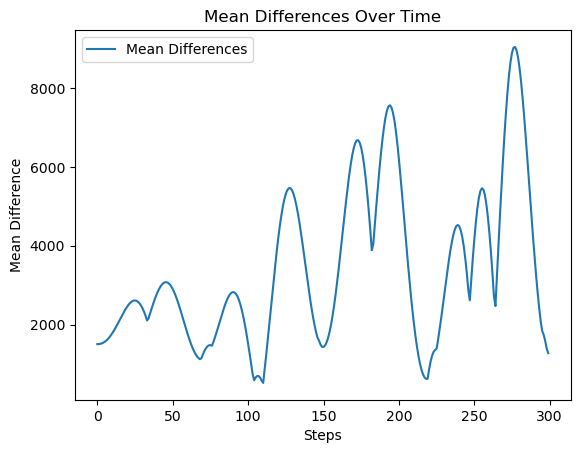

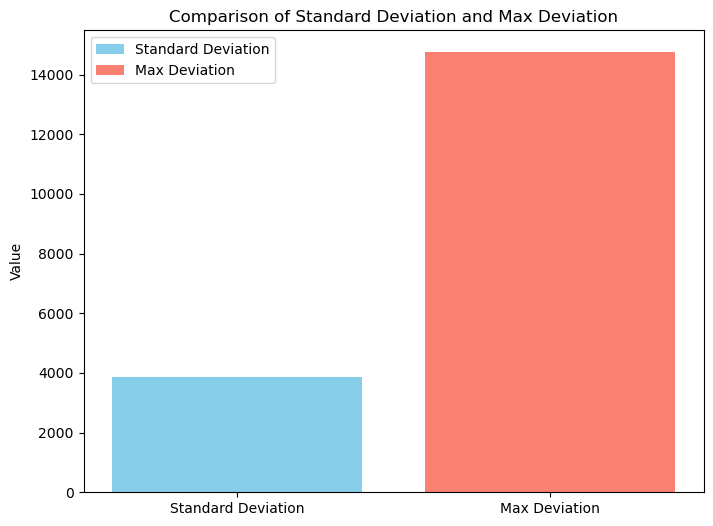

Mean Difference: 10234.771365276087
Standard Deviation: 3858.180409713016
Max Deviation: 14745.723596647982
Statistical values and images saved successfully.


In [6]:
# 17. Оценка производительности датчиков с визуализациями.

import matplotlib.pyplot as plt
import pandas as pd
import os

# Load data from adjusted_triangulated_coordinates.xlsx (simulated data)
data = pd.read_excel('D://Python_Project_Tracking//adjusted_triangulated_coordinates.xlsx')

# Extract X, Y, and Z coordinates from the loaded data
object_positions_x = data['X'].tolist()
object_positions_y = data['Y'].tolist()
object_positions_z = data['Z'].tolist()

# Define sensor positions within the range of -100 to 1000 for x, y, and z axes
sensor_positions = [
    (-10000, -10000, 0),  # Sensor 1 position (x, y, z)
    (13000, -13000, 0),  # Sensor 2 position (x, y, z)
    (0, 14000, 0),       # Sensor 3 position (x, y, z)
]

# Calculate differences or discrepancies
differences = []
for i in range(len(object_positions_x)):
    object_pos = (object_positions_x[i], object_positions_y[i], object_positions_z[i])
    sensor_distances = [((object_pos[0] - sensor[0])**2 + (object_pos[1] - sensor[1])**2 + (object_pos[2] - sensor[2])**2)**0.5
                        for sensor in sensor_positions]
    differences.append([abs(dist - min(sensor_distances)) for dist in sensor_distances])

# Calculate Assessment Metrics
mean_difference = sum(sum(step) for step in differences) / len(differences)
std_deviation = np.std(differences)
max_deviation = np.max(differences)

# Create a DataFrame for the statistical values
stats_data = pd.DataFrame({
    'Metric': ['Mean Difference', 'Standard Deviation', 'Max Deviation'],
    'Value': [mean_difference, std_deviation, max_deviation]
})

# Set the directory for saving files
output_directory = 'D://Python_Project_Tracking//statistical_values'
os.makedirs(output_directory, exist_ok=True)

# Save statistical values to Excel in the specified directory
stats_data.to_excel(os.path.join(output_directory, 'statistical_values.xlsx'), index=False)

# Visualization for Mean Differences and save the figure to the specified directory
plt.figure()
plt.plot(range(len(differences)), [sum(step) / len(step) for step in differences], label='Mean Differences')
plt.xlabel('Steps')
plt.ylabel('Mean Difference')
plt.title('Mean Differences Over Time')
plt.legend()
plt.savefig(os.path.join(output_directory, 'Mean_Difference.png'))

# Visualization for Standard Deviation and Max Deviation and save the figure to the specified directory
plt.figure(figsize=(8, 6))
plt.bar('Standard Deviation', std_deviation, color='skyblue', label='Standard Deviation')
plt.bar('Max Deviation', max_deviation, color='salmon', label='Max Deviation')
plt.title('Comparison of Standard Deviation and Max Deviation')
plt.ylabel('Value')
plt.legend()
plt.savefig(os.path.join(output_directory, 'Standard_Max_Deviation.png'))

plt.show()

# Print the calculated metrics
print(f"Mean Difference: {mean_difference}")
print(f"Standard Deviation: {std_deviation}")
print(f"Max Deviation: {max_deviation}")

print("Statistical values and images saved successfully.")
